# Face Recognition <a class="tocSkip">

In [81]:
from glob import glob

import cv2

## Data Preparation

In [82]:
PROCESSED_DIRPATH = './data/processed'
image_filepaths = glob(PROCESSED_DIRPATH + '/*')

In [84]:
data = []

for image_filepath in image_filepaths:
    cur_image = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE) / 255.
    cur_image = cur_image.flatten()
    data.append(cur_image)

## Principal Component Analysis

In [85]:
from sklearn.decomposition import PCA

### Obtaining the Principal Components

In [86]:
pca = PCA(len(data), random_state=1337)

reduced_data = pca.fit_transform(data)
principal_components = pca.components_
explained_variance = pca.explained_variance_ratio_

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

def plot_explained_variance(exp_var_ratio, tol=0.90):
    """Return explained variance plot given explained variance ratio

    Parameters
    ----------
    exp_var_ratio : numpy array
        Array containing the percentage of variance explained by
        each of the singular vectors.

    tol : float, default=0.90
        Default tolerance value for the optimal threshold

    Returns
    -------
    fig, ax : matplotlib figure and axes
        Figure and axes of the plot
    """
    # Get cumsum of explained variance ratio
    exp_var = (exp_var_ratio).cumsum()

    # Get index where exp_var exceeds tolerance
    thresh = np.min(np.arange(len(exp_var))[exp_var >= tol])

    # Initialize figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)

    # Plot explained varianced
    ax.plot(range(len(exp_var)), exp_var, lw=4.0)

    # Plot threshold line
    ax.axvline(thresh, linestyle='--', lw=2.5, color='tab:orange')
    
    # Annotate threshold
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.text(1.05*thresh, 0.05, f"Threshold: {int(thresh)}", color='tab:orange',
            weight='bold', fontsize=12, transform=trans)

    # Set ylim
    ax.set_ylim([min(exp_var), 1.05])
    ax.set_xlim([0., len(exp_var)])

    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set axis labels
    ax.set_xlabel('Number of components', fontsize=14)
    ax.set_ylabel('Cumulative explained variance', fontsize=14)
    
    return fig, ax, thresh

### Interpreting the Principal Components

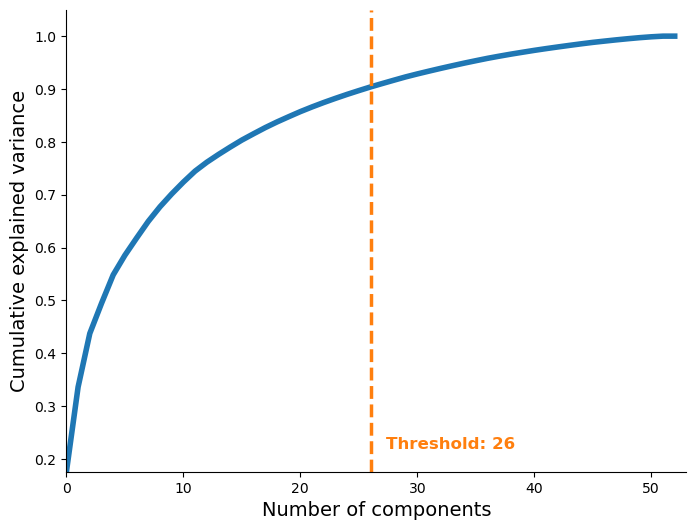

In [104]:
plot_explained_variance(explained_variance);

In [112]:
def plot_eigenfaces(
    principal_components, explained_variance, num_components_to_plot=10,
    figsize=(16, 6)):
    """Plot the eigenface annotated with their corresponding explained
    variance
    """
    num_columns = 5
    num_rows = num_components_to_plot // num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize)

    for i in range(num_components_to_plot):
        ax = axes.flatten()[i]
        cur_component = abs(principal_components[i, :])
        cur_explained_variance = round(explained_variance[i] * 100, 2)
        img_dim = int(np.sqrt(len(cur_component)))
        cur_component = cur_component.reshape((img_dim, img_dim))
        ax.imshow(cur_component)
        ax.set_title(f"PCA {i + 1} ({cur_explained_variance}%)", fontsize=12, weight='bold')

    for ax in axes.flatten():
        ax.axis('off')

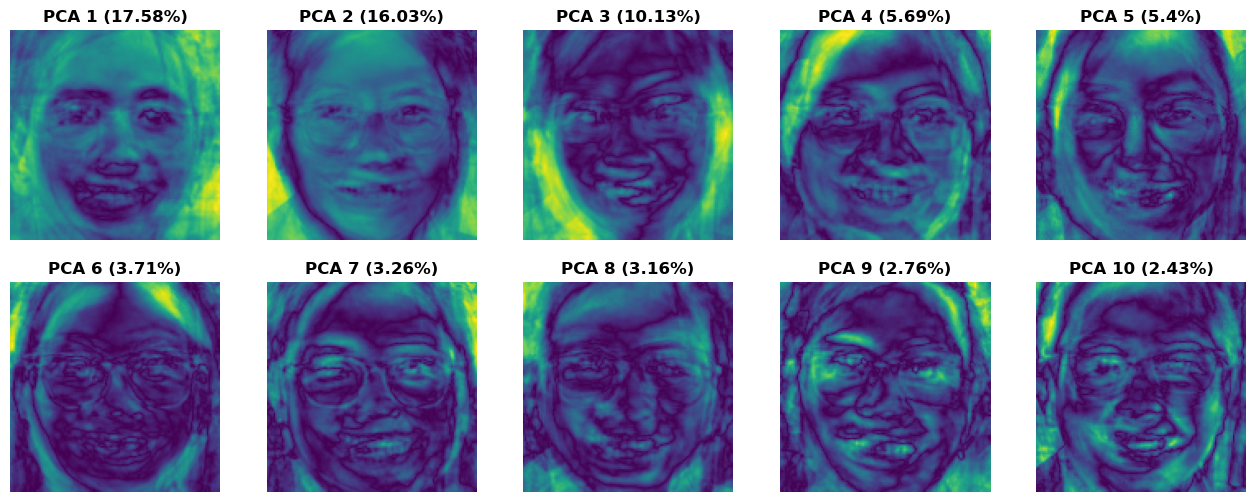

In [113]:
plot_eigenfaces(principal_components, explained_variance)

## Model Building

### Core Idea

In [312]:
# Reference images
img_leo = cv2.imread('./data/processed/04-01.jpg', cv2.IMREAD_GRAYSCALE)
img_pat = cv2.imread('./data/processed/07-10.jpg', cv2.IMREAD_GRAYSCALE)
ref_classes = ['Leo', 'Pat']

# Test images
test_img_1 = cv2.imread('./data/processed/07-01.jpg', cv2.IMREAD_GRAYSCALE)
test_img_2 = cv2.imread('./data/processed/01-06.jpg', cv2.IMREAD_GRAYSCALE)

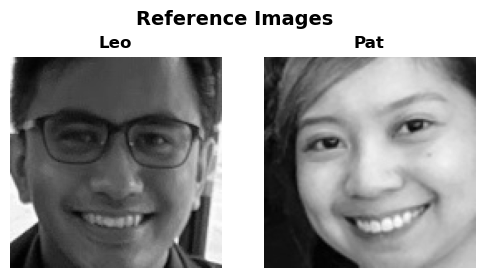

In [322]:
fig, axes = plt.subplots(1, 2, figsize=(6, 5))

for i, img in enumerate([img_leo, img_pat]):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(ref_classes[i], fontsize=12, weight='bold')
fig.suptitle("Reference Images", fontsize=14, weight='bold', y=0.80);

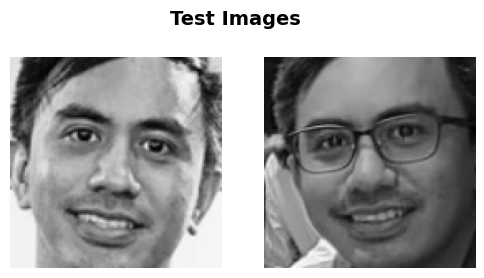

In [323]:
fig, axes = plt.subplots(1, 2, figsize=(6, 5))

for i, img in enumerate([test_img_1, test_img_2]):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
fig.suptitle("Test Images", fontsize=14, weight='bold', y=0.80);

### Core Idea in Action

In [324]:
def euclidean_distance(vector_1, vector_2):
    """Return the euclidean distance between two vectors"""
    return np.sqrt(((vector_1 - vector_2)**2).sum())

In [331]:
def plot_pair_distance(image_1, image_2, pca, titles, metric):
    """Plot the two images then computes for the distance between the
    PCA vectors of the two images
    """
    pca_1 = pca.transform(image_1.flatten()[np.newaxis, :] / 255.)[0]
    pca_2 = pca.transform(image_2.flatten()[np.newaxis, :] / 255.)[0]
    distance = metric(pca_1, pca_2)

    fig, axes = plt.subplots(1, 2, figsize=(6, 5))
    for i, img in enumerate([image_1, image_2]):
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(titles[i], fontsize=14, weight='bold')

    fig.suptitle(f'Distance: {distance:.4f}', fontsize=14, weight='bold', y=0.25)

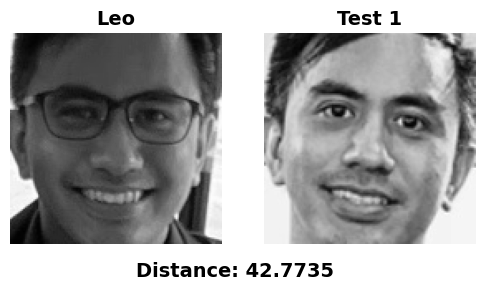

In [332]:
plot_pair_distance(img_leo, test_img_1, pca, ['Leo', 'Test 1'], euclidean_distance)

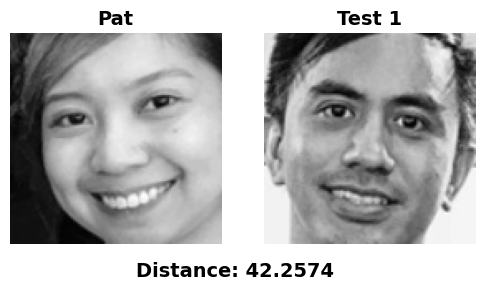

In [333]:
plot_pair_distance(img_pat, test_img_1, pca, ['Pat', 'Test 1'], euclidean_distance)

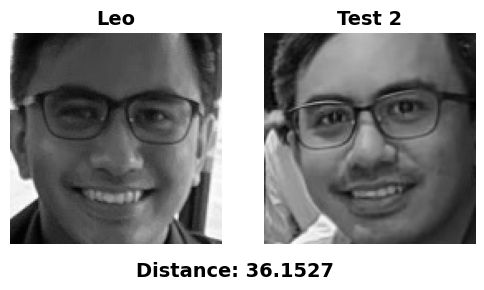

In [335]:
plot_pair_distance(img_leo, test_img_2, pca, ['Leo', 'Test 2'], euclidean_distance)

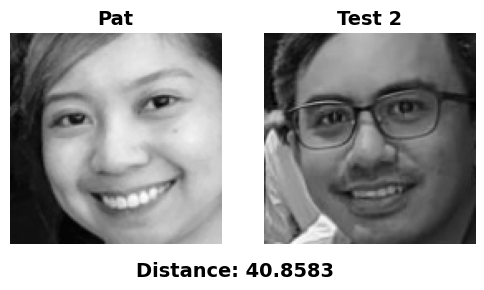

In [336]:
plot_pair_distance(img_pat, test_img_2, pca, ['Pat', 'Test 2'], euclidean_distance)

In [301]:
from scipy.spatial.distance import cosine

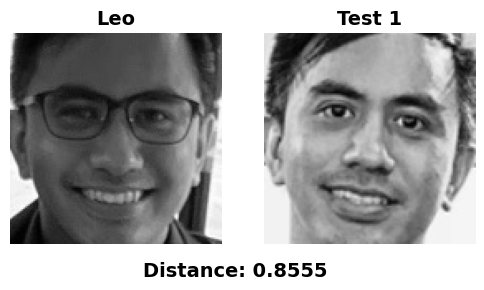

In [337]:
plot_pair_distance(img_leo, test_img_1, pca, ['Leo', 'Test 1'], cosine)

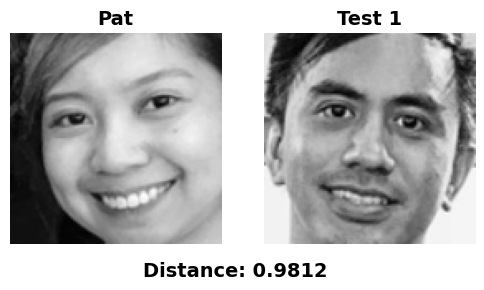

In [338]:
plot_pair_distance(img_pat, test_img_1, pca, ['Pat', 'Test 1'], cosine)

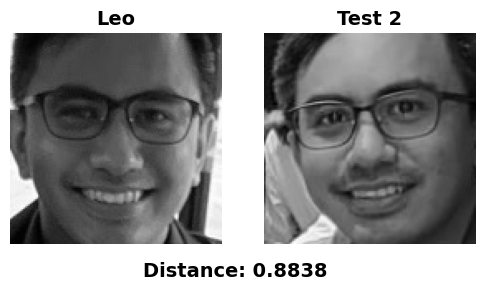

In [339]:
plot_pair_distance(img_leo, test_img_2, pca, ['Leo', 'Test 2'], cosine)

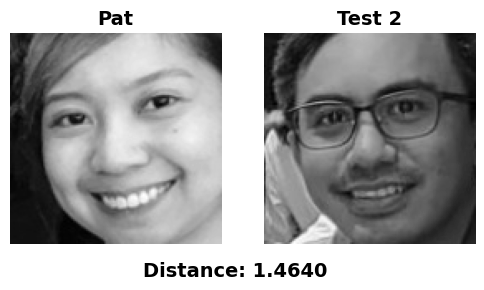

In [340]:
plot_pair_distance(img_pat, test_img_2, pca, ['Pat', 'Test 2'], cosine)

### Building Our Facial Recognition Model

In [380]:
class FacialRecognitionModel:
    """A machine learning model that predicts which face a given test
    input is based on reference images
    """
    def __init__(self, ref_images, pca):
        """Initialize the facial recognition model

        Parameters
        ----------
        ref_images : dict
            Dictionary containing the label and image filepath of the
            reference images
        pca : trained sklearn PCA model
            Trained sklearn PCA model using the relevant several images
        """
        # Initialize attributes of this object
        self.ref_images = ref_images
        self.pca = pca
        self.images = {}
        self.labels = []
        self.pcas = {}

        # Generate and compute for the items needed to deploy the model
        for label in ref_images:
            self.labels.append(label)

            # Read image then compute for PCA
            image = cv2.imread(ref_images[label], cv2.IMREAD_GRAYSCALE)
            image_pca = pca.transform(image.flatten()[np.newaxis, :] / 255.)[0]

            # Append the image arrays and computed pca vectors
            self.images[label] = image
            self.pcas[label] = image_pca

    def predict(self, test_image_filepath, metric=cosine):
        """Predict the label of the test image given its filepath.

        Generates the test image along with the prediction annotated
        with the distance of the test image with the reference images

        Parameters
        ----------
        test_image_filepath : str or Path
            Filepath of the test image
        metric : function
            Function that takes in two vectors then returns the distance
            between two vectors
        """
        # Read the test image and compute for its PCA
        test_image = cv2.imread(test_image_filepath, cv2.IMREAD_GRAYSCALE)
        test_pca = pca.transform(test_image.flatten()[np.newaxis, :] / 255.)[0]

        # Plot the test image
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(test_image, cmap='gray')
        ax.set_title("Test image", fontsize=14, weight='bold')
        ax.axis('off')

        # Plot the reference images along with its distance with the
        # test image
        fig, axes = plt.subplots(1, len(self.images), figsize=(16, 5))

        distances = {}
        for i, label in enumerate(self.labels):
            distance = metric(self.pcas[label], test_pca)
            distances[label] = distance

            ax = axes.flatten()[i]
            ax.imshow(self.images[label], cmap='gray')
            ax.axis('off')
            ax.set_title(f"{label} (dist: {distance:0.4f})", fontsize=14, weight='bold')

        prediction = sorted(self.labels, key=lambda x: distances[x])[0]
        fig.suptitle(f"Prediction: {prediction}", fontsize=16, weight='bold')

In [376]:
ref_images = {'Leo': './data/processed/04-01.jpg',
              'Pat': './data/processed/07-10.jpg',}

model = FacialRecognitionModel(ref_images, pca)

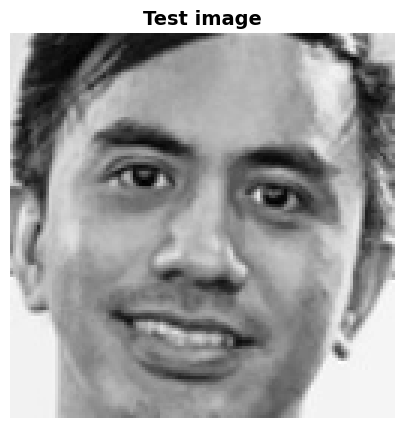

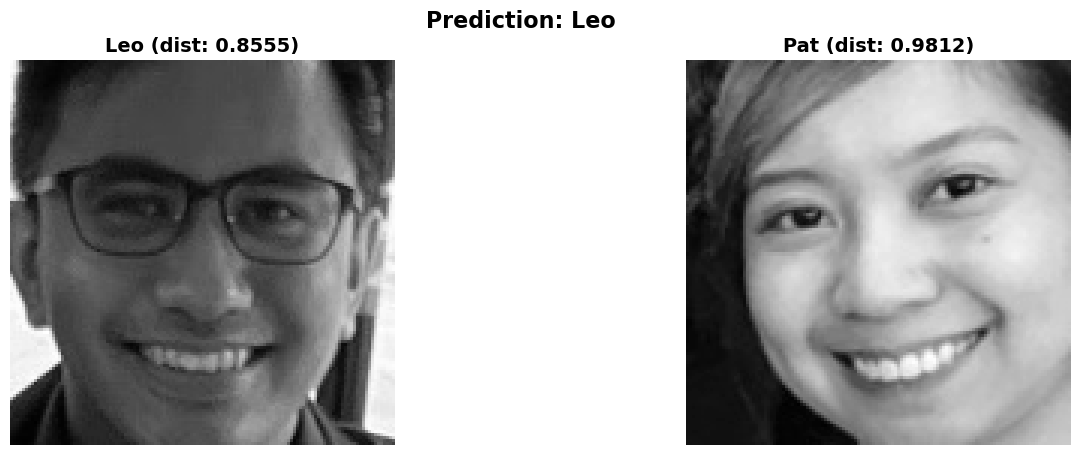

In [379]:
model.predict('./data/processed/07-01.jpg')